# SD201 project

# Recommendations based on hours played : k-nn on players
The aim of the algorithm is to predict a list of games someone may like knowing how much he played to other games.
It means that the feature we want to predict is a list of games, and the features used to do so are, for each game in the database, the amount of hours spent playing this game.

We then want X, Y like this :  
X = [0,0,...,0,5.2,0,10,...]  
Y = [0,1,1,0,0,1,...] (the one-encoded vector of the games liked) 

To determine the k neighbors, we will use the L2 distance on the vectors of hours played for each game.  
With this distance, firstly people that played a lot the same games will be near from each other, but it will also cluster types of players : those who play a lot of different games will be together, and the niche player will be separated.  

To make a prediction, we will compute using this distance the k neighbors of a player, and make a prediction.  
For this prediction, the k-nn algorithm usually choses the majority class of the neighbors. Thus, we could define a class as the one-hot-encoding of the games played by the user. However, this may lead to 1 class per neighbor, as it is highly possible that every player in the neighborhood, even if they are close one to each other, have tried a game the other ones never played to.  
That's why we choose as a result to give the union of all the games played by the neighbors. This will guarantee that the games resulting will be chosen because they are characteristical of the neighborhood.  
Obviously, we will remove from the result the games already played by the initial player (we don't want to recommand to someone a game he already played for 200 hours...)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
#Get the data

#read data
data = pd.read_csv('steam-200k.csv')
#clean data
data.columns = ['id','game','state','hours_played','0']
data = data.drop('0',axis=1)
played_games = data.loc[data['state']=='play']

In [4]:
played_games.head()

,id,game,state,hours_played
0,151603712,The Elder Scrolls V Skyrim,play,273.0
2,151603712,Fallout 4,play,87.0
4,151603712,Spore,play,14.9
6,151603712,Fallout New Vegas,play,12.1
8,151603712,Left 4 Dead 2,play,8.9


In [5]:
#Get a dict of games and hours played for each id
played_dict = played_games.groupby('id').apply(lambda g : dict(zip(g['game'], g['hours_played'])))
played_dict.head()

id
5250      {'Cities Skylines': 144.0, 'Deus Ex Human Revo...
76767     {'Counter-Strike': 365.0, 'Call of Duty World ...
86540     {'The Elder Scrolls V Skyrim': 113.0, 'Audiosu...
144736                              {'Counter-Strike': 0.1}
181212    {'Counter-Strike': 1.8, 'Half-Life 2 Lost Coas...
dtype: object

In [6]:
#Create vectors of hours played 
hours_encoded = played_dict.apply(pd.Series)
#Replace NaN values by 0 : a game not in the dict has never been played
hours_encoded = hours_encoded.fillna(0)
#We drop the ids because they are not useful anymore
hours_encoded = hours_encoded.reset_index(drop=True)
#Sort by name of games
hours_encoded = hours_encoded.reindex(sorted(hours_encoded.columns),axis=1)
hours_encoded.head()

,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#Get the list of games
games_list = list(hours_encoded.columns)
games_list.sort()
len(games_list)

3600

In [8]:
#We now create our "classes" : the list of games played by each player
played_list = played_games.groupby('id')['game'].apply(list).reset_index(drop=True)
played_list.head()

0    [Cities Skylines, Deus Ex Human Revolution, Po...
1    [Counter-Strike, Call of Duty World at War, To...
2    [The Elder Scrolls V Skyrim, Audiosurf, XCOM E...
3                                     [Counter-Strike]
4             [Counter-Strike, Half-Life 2 Lost Coast]
Name: game, dtype: object

In [9]:
#And we one-hot encode them
from sklearn.preprocessing import MultiLabelBinarizer
#One-hot-encode the lists
mlb = MultiLabelBinarizer()

played_encoded = pd.DataFrame(mlb.fit_transform(played_list),
                   columns=mlb.classes_)

played_encoded.head()

,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
#Create training, validation and testing sets with a 80/10/10 repartition
#We just let the bought games in y values, but labels are not useful there because we will only compute the
#neighbors and find the result ourselves
from sklearn.model_selection import train_test_split
X, X_validation, y, y_validation = train_test_split(hours_encoded, played_encoded, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)

#Standardize only the training set so that validation and testing are not impacted
#We standardize each column separately

def standardize(c):
    m = c.mean()
    if c.std() > 0:
        std = c.std()
    else:
        std = 1e-8
    return (c-m)/std

X_train = X_train.apply(lambda column : standardize(column),axis=0)
X_train.head()

,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
277,-0.01043,-0.014751,-0.016613,-0.01043,-0.01043,-0.014083,0.0,-0.016805,-0.016944,-0.015594,...,0.0,-0.01043,-0.013994,-0.01043,-0.026495,-0.01043,-0.044698,-0.022017,-0.029283,-0.012353
2384,-0.01043,-0.014751,-0.016613,-0.01043,-0.01043,-0.014083,0.0,-0.016805,-0.016944,-0.015594,...,0.0,-0.01043,-0.013994,-0.01043,-0.026495,-0.01043,-0.044698,-0.022017,-0.029283,-0.012353
10152,-0.01043,-0.014751,-0.016613,-0.01043,-0.01043,-0.014083,0.0,-0.016805,-0.016944,-0.015594,...,0.0,-0.01043,-0.013994,-0.01043,-0.026495,-0.01043,-0.044698,-0.022017,-0.029283,-0.012353
2509,-0.01043,-0.014751,-0.016613,-0.01043,-0.01043,-0.014083,0.0,-0.016805,-0.016944,-0.015594,...,0.0,-0.01043,-0.013994,-0.01043,-0.026495,-0.01043,-0.044698,-0.022017,-0.029283,-0.012353
4662,-0.01043,-0.014751,-0.016613,-0.01043,-0.01043,-0.014083,0.0,-0.016805,-0.016944,-0.015594,...,0.0,-0.01043,-0.013994,-0.01043,-0.026495,-0.01043,-0.044698,-0.022017,-0.029283,-0.012353


Let's check if our data and labels are coherent

In [11]:
X_train.iloc[150]

007 Legends                                                  -0.010430
0RBITALIS                                                    -0.014751
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)   -0.016613
10 Second Ninja                                              -0.010430
10,000,000                                                   -0.010430
                                                                ...   
rymdkapsel                                                   -0.010430
sZone-Online                                                 -0.044698
the static speaks my name                                    -0.022017
theHunter                                                     1.169609
theHunter Primal                                             -0.012353
Name: 1441, Length: 3600, dtype: float64

In [12]:
#To retrieve the list of played games, we get the list of games with a
#non zero time played and check the name corresponding to the index
def games_of_player(i):
    return [games_list[index] for index in list(np.asarray(y_train.iloc[i]).nonzero())[0]]

games_of_player(110)

['Call of Duty Black Ops',
 'Call of Duty Black Ops - Multiplayer',
 'Call of Duty Modern Warfare 3 - Multiplayer',
 'Counter-Strike Source',
 'Day of Defeat Source',
 'Fallout New Vegas',
 'Game of Thrones ',
 'Lead and Gold - Gangs of the Wild West',
 'Mafia II',
 'Max Payne 3',
 'Risen 2 - Dark Waters',
 'Rising Storm/Red Orchestra 2 Multiplayer']

In [13]:
X_train.iloc[110][['Counter-Strike Source','Fallout New Vegas','Call of Duty Modern Warfare 3 - Multiplayer']]

Counter-Strike Source                          0.779048
Fallout New Vegas                              0.938599
Call of Duty Modern Warfare 3 - Multiplayer    0.293190
Name: 706, dtype: float64

It seems clean! Let's implement the knn algorithm

In [14]:
from sklearn.neighbors import NearestNeighbors

We will choose 100 neighbors. As we have almost 10000 users, it means we link a player to 1% of the dataset, which seems to be a fair choice.

In [15]:
neigh = NearestNeighbors(n_neighbors=100, metric='euclidean')
neigh.fit(X_train.values)

NearestNeighbors(metric='euclidean', n_neighbors=100)

In [16]:
X_train.mean(axis=0)['007 Legends']

4.923486017881856e-16

In [17]:
#To test, we standardize the test vector according to the training values (which is different from standardizing the whole dataset)
#To do so, we create a dict of mean and std for each game in the training set
mean_dict = X_train.mean(axis=0)
std_dict = X_train.std(axis=0)
std_dict.replace(to_replace=0,value=1e-8,inplace=True)

In [18]:
stand_vector = (X_validation.iloc[200]-mean_dict)/std_dict
kn = neigh.kneighbors([stand_vector])

In [19]:
[games_list[index] for index in list(np.asarray(y_validation.iloc[200]).nonzero())[0]]

['Dota 2']

In [20]:
kn[1]

array([[6339, 4986, 6254, 7194,  876, 4784,  797, 4845, 4603, 3202, 4708,
        6487, 1339, 8210, 8504, 6207, 5372,  215,  405, 6403, 7989, 4014,
         750, 4435, 3405, 7648, 3882, 8030,  362, 2958, 8478, 4006, 2428,
        5384, 7843, 8278,  586, 4771, 3984, 4439, 3575, 3310, 4019, 4197,
        2953, 4012, 7756, 1962, 6483, 5226, 7327, 3230,  696,   97, 9085,
        2084, 6139, 3887, 3711, 9129, 4714, 1483, 7012, 8633, 5015, 8876,
        4186, 6260, 6153, 6322, 7709, 5846, 2430,  595, 3157, 3353, 2682,
        6107,  911, 4453,  844, 4415, 2922, 1423,  712, 6640,  606, 3132,
        1941, 4254, 1024, 5054, 2627, 2433, 9168,  172, 1411, 8362, 4128,
        1513]])

In [21]:
games_of_player(6339)

['Dota 2']

In [22]:
stand_vector['Dota 2']

0.8000000000000302

In [23]:
X_train.iloc[6339]['Dota 2']

0.8029278243452672

We notice that a lot of players have played the same popular games, and some of them have only played those ones.
In our example, the algorithm found a lot of neighbors that played the exact same time to Dota 2 than the initial player, and thus are chosen even thought they only played to Dota, which means we can't find a game to recommand.  
-> **outliers**  

Let's try to take only the players that played a minimum of 3 games.  

As we will have much less data, we will only take 5 neighbors.

In [24]:
played_dict_3 = played_dict.loc[played_dict.map(len)>=3]
played_dict_3.head()

id
5250      {'Cities Skylines': 144.0, 'Deus Ex Human Revo...
76767     {'Counter-Strike': 365.0, 'Call of Duty World ...
86540     {'The Elder Scrolls V Skyrim': 113.0, 'Audiosu...
229911    {'Counter-Strike Condition Zero': 165.0, 'Call...
298950    {'Team Fortress 2': 1019.0, 'Counter-Strike Gl...
dtype: object

In [25]:
#Create vectors of hours played 
hours_encoded_3 = played_dict_3.apply(pd.Series)
#Replace NaN values by 0 : a game not in the dict has never been played
hours_encoded_3 = hours_encoded_3.fillna(0)
#We drop the ids because they are not useful anymore
hours_encoded_3 = hours_encoded_3.reset_index(drop=True)
#Sort by name of games
hours_encoded_3 = hours_encoded_3.reindex(sorted(hours_encoded_3.columns),axis=1)

#Get the list of games
games_list = list(hours_encoded_3.columns)
games_list.sort()

#We now create our "classes" : the list of games played by each player
played_list_3 = played_list.loc[played_list.map(len)>=3]

#And we one-hot encode them
mlb = MultiLabelBinarizer()

played_encoded_3 = pd.DataFrame(mlb.fit_transform(played_list_3),
                   columns=mlb.classes_)


X, X_validation, y, y_validation = train_test_split(hours_encoded_3, played_encoded_3, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)

#Standardize only the training set so that validation and testing are not impacted
#We standardize each column separately

def standardize(c):
    m = c.mean()
    if c.std() > 0:
        std = c.std()
    else:
        std = 1e-8
    return (c-m)/std

X_train = X_train.apply(lambda column : standardize(column),axis=0)

mean_dict = X_train.mean(axis=0)
std_dict = X_train.std(axis=0)
std_dict.replace(to_replace=0,value=1e-8,inplace=True)


#To retrieve the list of played games, we get the list of games with a
#non zero time played and check the name corresponding to the index
def games_of_player_train(i):
    return [games_list[index] for index in list(np.asarray(y_train.iloc[i]).nonzero())[0]]

def games_of_player_validation(i):
    return [games_list[index] for index in list(np.asarray(y_validation.iloc[i]).nonzero())[0]]

neigh = NearestNeighbors(n_neighbors=5, metric='euclidean')
neigh.fit(X_train.values)

NearestNeighbors(metric='euclidean')

In [26]:
games_of_player_validation(30)

['Far Cry',
 'Far Cry 3',
 'Far Cry 3 Blood Dragon',
 'Grand Theft Auto V',
 'Team Fortress 2',
 'The Elder Scrolls V Skyrim']

In [27]:
stand_vector = (X_validation.iloc[30]-mean_dict)/std_dict
kn = neigh.kneighbors([stand_vector])
kn

(array([[93.00010771, 97.37528489, 97.44419096, 97.65609646, 97.86985575]]),
 array([[1565,  747,  294, 2540, 2406]]))

In [28]:
games_of_player_train(2540)

['Age of Empires II HD Edition',
 'Banished',
 'Fallout 4',
 'Grand Theft Auto V',
 'Grand Theft Auto Vice City',
 'Mass Effect',
 'Test Drive Unlimited 2',
 'The Elder Scrolls IV Oblivion ',
 'The Elder Scrolls V Skyrim',
 'The Witcher 3 Wild Hunt']

In [29]:
games_of_player_train(2406)

['ARK Survival Evolved',
 'ArcheAge',
 'DC Universe Online',
 'Dota 2',
 'Fallout 4',
 'Fallout New Vegas',
 'Neverwinter',
 'RaiderZ',
 'SMITE',
 'TERA',
 'The Elder Scrolls III Morrowind',
 'The Elder Scrolls V Skyrim',
 'The Witcher 2 Assassins of Kings Enhanced Edition',
 'Universe Sandbox',
 'Warframe']

The results seem pretty good : the neighbors have played games of the same genre as the initial player.  

However, if we do what we explained before : take the union of games played by the neighbors, we quickly realise that we will have a lot of games recommanded. Moreover, those recommandations may be irrelevant : if someone close played a game for only a few hours, it probably means that he didn't like it and thus we should not recommand it to the same type of player.  

That's why we will take the games **liked** by the neighbors. To do so, we will define a game as liked if a player has played more than the average time spent on the game by all the players of the dataset that have launched the game (not to take into account all the players that did not buy it).  

Unluckily, we don't know since when the games were bought, and this method can thus qualify some games as not liked even if someone just bougt it and did not have enough time to play it. But we will consider that this case is rare enough not to disturb the results.

In [30]:
played_dict_3 = played_dict.loc[played_dict.map(len)>=3]
played_dict_3.head()

id
5250      {'Cities Skylines': 144.0, 'Deus Ex Human Revo...
76767     {'Counter-Strike': 365.0, 'Call of Duty World ...
86540     {'The Elder Scrolls V Skyrim': 113.0, 'Audiosu...
229911    {'Counter-Strike Condition Zero': 165.0, 'Call...
298950    {'Team Fortress 2': 1019.0, 'Counter-Strike Gl...
dtype: object

In [31]:
played_dict_3.iloc[2]

{'The Elder Scrolls V Skyrim': 113.0,
 'Audiosurf': 57.0,
 'XCOM Enemy Unknown': 37.0,
 'Far Cry 3': 17.8,
 'Left 4 Dead 2': 16.4,
 'Killer is Dead': 5.3,
 'Torchlight II': 3.6,
 'The Walking Dead': 1.8,
 'Max Payne 3': 0.9,
 'Borderlands 2': 0.7,
 'Age of Empires II HD Edition': 0.7,
 'Serious Sam HD The First Encounter': 0.2,
 'Portal': 0.2,
 "Tom Clancy's Ghost Recon Advanced Warfighter": 0.2,
 'Alan Wake': 0.2}

In [32]:
#Let's compute the liked games for each player

#To do so, we will compute the average played time for each game that has been at least launched
non_zero_dict = hours_encoded.replace(0, np.NaN)
average_played = non_zero_dict.mean(axis=0)

def dict_to_liked(dicti):
    d = dicti.copy()
    for game in d.keys():
        if d[game] > average_played[game]:
            d[game]=1
        else:
            d[game]=0
    return d

#For each player that played at least 3 games, we compute the list of game he like
liked_games = played_dict_3.map(dict_to_liked)
liked_games

id
5250         {'Cities Skylines': 1, 'Deus Ex Human Revoluti...
76767        {'Counter-Strike': 1, 'Call of Duty World at W...
86540        {'The Elder Scrolls V Skyrim': 1, 'Audiosurf':...
229911       {'Counter-Strike Condition Zero': 1, 'Call of ...
298950       {'Team Fortress 2': 1, 'Counter-Strike Global ...
                                   ...                        
306547522    {'Warface': 0, 'Dota 2': 0, 'Strife': 0, 'Team...
306971738    {'The Elder Scrolls IV Oblivion ': 0, 'Terrari...
308695132    {'La Tale': 0, 'Champions Online': 0, 'Brawlha...
308760273    {'Toribash': 0, 'Unturned': 0, 'Team Fortress ...
309404240    {'Unturned': 0, 'Team Fortress 2': 0, 'Mitos.i...
Length: 3466, dtype: object

In [33]:
#And encode them
liked_games_encoded = liked_games.apply(pd.Series)
#Replace NaN values by 0 : a game not in the dict has never been played
liked_games_encoded = liked_games_encoded.fillna(0)
liked_games_encoded = liked_games_encoded.reindex(sorted(liked_games_encoded.columns),axis=1)
liked_games_encoded

,007 Legends,0RBITALIS,1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby),10 Second Ninja,"10,000,000",100% Orange Juice,1000 Amps,12 Labours of Hercules,12 Labours of Hercules II The Cretan Bull,12 Labours of Hercules III Girl Power,...,rFactor,rFactor 2,realMyst,realMyst Masterpiece Edition,resident evil 4 / biohazard 4,rymdkapsel,sZone-Online,the static speaks my name,theHunter,theHunter Primal
id,,,,,,,,,,,,,,,,,,,,,
5250,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76767,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
86540,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
229911,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
298950,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
306547522,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
306971738,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
308695132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [34]:
hours_encoded_3 = played_dict_3.apply(pd.Series)
#Replace NaN values by 0 : a game not in the dict has never been played
hours_encoded_3 = hours_encoded_3.fillna(0)
hours_encoded_3 = hours_encoded_3.reindex(sorted(hours_encoded_3.columns),axis=1)

We can then rebuild our model using liked_games as our new classes, as that is exactly what we want to predict : what games the player could like

In [35]:
#Get the list of games
games_list = list(hours_encoded_3.columns)
games_list.sort()

X, X_validation, y, y_validation = train_test_split(hours_encoded_3, liked_games_encoded, test_size=0.1, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.1, random_state=42)

#Standardize only the training set so that validation and testing are not impacted
#We standardize each column separately

def standardize(c):
    m = c.mean()
    if c.std() > 0:
        std = c.std()
    else:
        std = 1e-8
    return (c-m)/std

X_train = X_train.apply(lambda column : standardize(column),axis=0)

mean_dict = X_train.mean(axis=0)
std_dict = X_train.std(axis=0)
std_dict.replace(to_replace=0,value=1e-8,inplace=True)


#To retrieve the list of played games, we get the list of games with a
#non zero time played and check the name corresponding to the index
def games_of_player_train(i):
    return [games_list[index] for index in list(np.asarray(X_train.iloc[i]).nonzero())[0]]

def games_of_player_validation(i):
    return [games_list[index] for index in list(np.asarray(y_validation.iloc[i]).nonzero())[0]]

neigh = NearestNeighbors(n_neighbors=5, metric='euclidean')
neigh.fit(X_train.values)

NearestNeighbors(metric='euclidean')

We can now create our recommendation function :  

Taking :  
- a player X, ie a vector of hours played for each game  
- a knn model fitted on values as shown before  
- the samples used for training

It returns :  
- the list of games liked by the k neighbors that X never played

In [36]:
def recommendations(X, model, samples):
    #Get the list of games played by X
    already_owned = [games_list[index] for index in np.asarray(X).nonzero()[0]]
    stand_vector = (X-mean_dict)/std_dict
    
    #Returns the union of games liked by neighbors 
    kneighbors = model.kneighbors([stand_vector])[1][0] #We get the indices of the neighbors
    
    recommandations = []
    for neighbor in kneighbors:
        recommandations = recommandations+[games_list[index] for index in np.asarray(samples.iloc[neighbor]).nonzero()[0]]
    
    #remove duplicates
    recommandations = list(dict.fromkeys(recommandations))
    
    #remove games already owned by X
    recommandations = [game for game in recommandations if game not in already_owned]
    
    return recommandations

In [37]:
games_of_player_validation(125)

['Call of Duty 4 Modern Warfare',
 'Ricochet',
 'Serious Sam HD The First Encounter']

In [38]:
recom = recommendations(X_validation.iloc[125], neigh, y_train)
print(len(recom))
print(recom)

12
['APB Reloaded', 'Arma 2 Operation Arrowhead', 'Insurgency', 'Arma 2', 'Call of Duty Black Ops', 'Contagion', 'Dungeon Defenders', 'Torchlight II', 'Counter-Strike Global Offensive', 'Empire Total War', 'Medieval II Total War', 'Total War SHOGUN 2']


In [39]:
#Let's create a test rpg player to test the recommendations
test_player = {'The Witcher 3 Wild Hunt':250,'The Elder Scrolls V Skyrim':224, 'Far Cry':90, 'Fallout 3':70}
encoded_player = pd.Series(test_player,index=games_list).fillna(0)
encoded_player

007 Legends                                                   0.0
0RBITALIS                                                     0.0
1... 2... 3... KICK IT! (Drop That Beat Like an Ugly Baby)    0.0
10 Second Ninja                                               0.0
10,000,000                                                    0.0
                                                             ... 
rymdkapsel                                                    0.0
sZone-Online                                                  0.0
the static speaks my name                                     0.0
theHunter                                                     0.0
theHunter Primal                                              0.0
Length: 3564, dtype: float64

In [40]:
recommendations(encoded_player, neigh, y_train)

["Assassin's Creed III",
 "Assassin's Creed IV Black Flag",
 'Assassins Creed Unity',
 'Crayon Physics Deluxe',
 'Fallout 4',
 'Far Cry 3',
 'Grand Theft Auto V',
 'Saints Row IV',
 'The Witcher 2 Assassins of Kings Enhanced Edition',
 'The Witcher Enhanced Edition',
 'Divinity Original Sin',
 'Divinity Original Sin Enhanced Edition',
 'Fallout 2',
 'STAR WARS Knights of the Old Republic II The Sith Lords',
 'ArcaniA',
 'Half-Life 2 Episode One',
 'The Darkness II',
 'Tomb Raider',
 'BioShock Infinite',
 'Braid',
 'Dota 2',
 'Grand Theft Auto IV']

We get results that seem coherent (for this example we have same genre like rpgs, also series of games already played), but there are too much of them.  

To prevent this, we will firstly give a score to each result to determine the priority of recommendations, and then define how much maximum results we want.  

**Score**  
The score of a predicted game will be equal to the sum of the inverse distances to each neighbor, weighted by how much the neighbors liked the game (the difference between the hours played and the mean).  
With this score, the more a game has been played by people who like the same games and the more it has been liked by them, the more it will have chances to be predicted.  

To do so, we set to 0 the negative values of hours, meaning that we only keep games likes and the value will be proportional to the difference to the average.

In [41]:
non_zero_dict = hours_encoded.replace(0, np.NaN)
average_played = non_zero_dict.mean(axis=0)

def dict_to_likeness(dicti):
    d = dicti.copy()
    for game in d.keys():
        if d[game] <= average_played[game]:
            d[game]=0
    return d

#For each player that played at least 3 games, we compute the list of game he like
likeness_games = played_dict_3.map(dict_to_likeness)
likeness_games

id
5250         {'Cities Skylines': 144.0, 'Deus Ex Human Revo...
76767        {'Counter-Strike': 365.0, 'Call of Duty World ...
86540        {'The Elder Scrolls V Skyrim': 113.0, 'Audiosu...
229911       {'Counter-Strike Condition Zero': 165.0, 'Call...
298950       {'Team Fortress 2': 1019.0, 'Counter-Strike Gl...
                                   ...                        
306547522    {'Warface': 0, 'Dota 2': 0, 'Strife': 0, 'Team...
306971738    {'The Elder Scrolls IV Oblivion ': 0, 'Terrari...
308695132    {'La Tale': 0, 'Champions Online': 0, 'Brawlha...
308760273    {'Toribash': 0, 'Unturned': 0, 'Team Fortress ...
309404240    {'Unturned': 0, 'Team Fortress 2': 0, 'Mitos.i...
Length: 3466, dtype: object

The new recommendation function will then return a vector of probabilities that the player may like each game.

In [42]:
#And encode them
likeness_games_encoded = likeness_games.apply(pd.Series)
#Replace NaN values by 0 : a game not in the dict has never been played
likeness_games_encoded = likeness_games_encoded.fillna(0)
likeness_games_encoded = likeness_games_encoded.reindex(sorted(likeness_games_encoded.columns),axis=1)

In [43]:
#We define a custom train test split function to shuffle the likeness with the two other dataframes
def train_test_validation_split_likeness(hours, liked_games, likeness, test_size=0.1, validation_size=0.1):
    
    #shuffle
    indexes = np.asarray(hours.index).copy()
    np.random.seed(42) #set seed for reproducability
    np.random.shuffle(indexes)
    hours_shuffled = hours.loc[indexes]
    liked_games_shuffled = liked_games.loc[indexes]
    likeness_shuffled = likeness.loc[indexes]
    
    #split train and test
    separator1 = len(hours) - int(len(hours)* (test_size+validation_size))
    separator2 = len(hours) - int(len(hours)* test_size)
    X_train = hours_shuffled.iloc[:separator1]
    y_train = liked_games_shuffled.iloc[:separator1]
    X_validation = hours_shuffled.iloc[separator1:separator2]
    y_validation = liked_games_shuffled.iloc[separator1:separator2]
    X_test = hours_shuffled.iloc[separator2:]
    y_test = liked_games_shuffled.iloc[separator2:]

    likeness_train = likeness_shuffled.iloc[:separator1]
    
    return X_train,X_validation,X_test,y_train,y_validation,y_test,likeness_train

In [44]:
X_train, X_test, X_validation, y_train, y_validation, y_test, likeness_train = train_test_validation_split_likeness(hours_encoded_3, liked_games_encoded, likeness_games_encoded)

#Standardize only the training set so that validation and testing are not impacted
#We standardize each column separately

def standardize(c):
    m = c.mean()
    if c.std() > 0:
        std = c.std()
    else:
        std = 1e-8
    return (c-m)/std

X_train = X_train.apply(lambda column : standardize(column),axis=0)

#we also standardize the likeness
likeness_train = likeness_train.apply(lambda column : standardize(column),axis=0)

mean_dict = X_train.mean(axis=0)
std_dict = X_train.std(axis=0)
std_dict.replace(to_replace=0,value=1e-8,inplace=True)

#To retrieve the list of played games, we get the list of games with a
#non zero time played and check the name corresponding to the index
def games_of_player_train(i):
    return [games_list[index] for index in list(np.asarray(X_train.iloc[i]).nonzero())[0]]

def games_of_player_validation(i):
    return [games_list[index] for index in list(np.asarray(X_validation.iloc[i]).nonzero())[0]]

def games_of_player_test(i):
    return [games_list[index] for index in list(np.asarray(X_test.iloc[i]).nonzero())[0]]

neigh = NearestNeighbors(n_neighbors=5, metric='euclidean')
neigh.fit(X_train.values)

NearestNeighbors(metric='euclidean')

In [45]:
def score(X, model, likeness):
    #Create a vector with all games and a null score
    score = pd.Series({games_list[0]:0.0},index=games_list).fillna(0)
    
    #Get the list of games played by X
    already_owned = [games_list[index] for index in np.asarray(X).nonzero()[0]]

    stand_vector = (X-mean_dict)/std_dict
    
    
    #Get the neighbors of X
    kneighbors = model.kneighbors([stand_vector])
    kneighbors_distances = kneighbors[0][0]
    kneighbors_indices = kneighbors[1][0]
    
    for i in range(len(kneighbors_indices)):
        neighbor = kneighbors_indices[i]
        #get the list of liked games
        liked = [games_list[index] for index in np.asarray(likeness.iloc[neighbor]).nonzero()[0]]
        #Add to each game score (1/d)*l with d the distance between X and the neighbor
        #and l the amount of time played above the average
        for liked_game in liked:
            if liked_game not in already_owned:
                score[liked_game] = score[liked_game] + 1/kneighbors_distances[i] + likeness.iloc[neighbor][liked_game]
            
    
    return score.sort_values(ascending=False)

In [46]:
dict(score(encoded_player, neigh, likeness_train))

{'Just Cause 3': 46.384380625303166,
 'Wargame Red Dragon': 22.61224631854759,
 'Crayon Physics Deluxe': 21.329437451828294,
 "Assassin's Creed IV Black Flag": 21.260779351669466,
 "Tom Clancy's Rainbow Six Siege": 18.951362722113505,
 'Saints Row IV': 18.120712818833766,
 'The Witcher 2 Assassins of Kings Enhanced Edition': 16.774942851201743,
 'LEGO The Lord of the Rings': 15.551598809128578,
 'Wolfenstein The New Order': 14.86376281917686,
 'Grand Theft Auto V': 14.169077354420441,
 'Fallout 4': 12.919416639380401,
 'Far Cry 4': 12.073603980238136,
 'ARK Survival Evolved': 11.854492130412584,
 'Assassins Creed Unity': 11.184238167256103,
 'METAL GEAR SOLID V THE PHANTOM PAIN': 11.022602144085317,
 'Middle-earth Shadow of Mordor': 9.364384074881581,
 'Divinity Original Sin Enhanced Edition': 9.192842311140483,
 'Call of Duty Black Ops III': 8.394526973819872,
 'Braid': 7.3804399850217495,
 'The Witcher Enhanced Edition': 5.112557173608053,
 "Assassin's Creed III": 4.680085596950468,


With this score, the results are much more satisfying ! With this very specific player, we see that the top 20 results are mostly RPGs, including games from series the player already played, which seems really relevant.

Now that our method is set, let's create a model class to clean everything

In [47]:
class SteamPredictionModel():
    
    def __init__(self, k_neighbors = 5):
        self.neigh = NearestNeighbors(n_neighbors=k_neighbors, metric='euclidean')
        self.games_list = []
        self.likeness = None
        self.mean_dict = {}
        self.std_dict = {}
        self.average_played = {}

    def dict_to_likeness(self, dicti):
        d = dicti.copy()
        for game in d.keys():
            if d[game] <= self.average_played[game]:
                d[game]=0
        return d
    
    #We fit the model on a dataset containing ids and dictionnaries of games associated with time played
    def fit(self, data):

        #Firstly we encode the hours played
        hours_encoded = data.apply(pd.Series)
        #Replace NaN values by 0 : a game not in the dict has never been played
        hours_encoded = hours_encoded.fillna(0)
        hours_encoded = hours_encoded.reindex(sorted(hours_encoded.columns),axis=1)
        

        #For each player, we compute the list of game he likes with the time he has played aboved average time played
        non_zero_dict = hours_encoded.replace(0, np.NaN)
        self.average_played = non_zero_dict.mean(axis=0)
        likeness_games = data.map(self.dict_to_likeness)
        #And encode them
        likeness_games_encoded = likeness_games.apply(pd.Series)
        #Replace NaN values by 0 : a game not in the dict has never been played
        likeness_games_encoded = likeness_games_encoded.fillna(0)
        likeness_games_encoded = likeness_games_encoded.reindex(sorted(likeness_games_encoded.columns),axis=1)

        #standardization
        #We standardize each column separately

        def standardize(c):
            m = c.mean()
            if c.std() > 0:
                std = c.std()
            else:
                std = 1e-8
            return (c-m)/std

        hours_encoded = hours_encoded.apply(lambda column : standardize(column),axis=0)

        #we store the mean and std to standardize vectors on which we want to make predictions
        self.mean_dict = hours_encoded.mean(axis=0)
        self.std_dict = hours_encoded.std(axis=0)
        self.std_dict.replace(to_replace=0,value=1e-8,inplace=True)

        #we also standardize the likeness
        likeness_games_encoded = likeness_games_encoded.apply(lambda column : standardize(column),axis=0)
        self.likeness = likeness_games_encoded



        self.neigh.fit(hours_encoded.values)
        
        #Get the list of games
        games_list = list(hours_encoded.columns)
        games_list.sort()
        self.games_list = games_list
        
        
    
    #We predict a certain number of games (maximum) using a dictionnary of games associated with time played
    def predict(self, X_init, recommendations_number_max):
        #One-hot-encode X
        X = pd.Series(X_init,index=self.games_list).fillna(0)
        
        #Create a vector with all games and a null score
        score = pd.Series({self.games_list[0]:0.0},index=self.games_list).fillna(0)

        #Get the list of games played by X
        already_owned = [self.games_list[index] for index in np.asarray(X).nonzero()[0]]

        
        stand_vector = (X-self.mean_dict)/self.std_dict
        #Get the neighbors of X
        kneighbors = self.neigh.kneighbors([stand_vector])
        kneighbors_distances = kneighbors[0][0]
        kneighbors_indices = kneighbors[1][0]

        for i in range(len(kneighbors_indices)):
            neighbor = kneighbors_indices[i]
            #get the list of liked games
            liked = [self.games_list[index] for index in np.asarray(self.likeness.iloc[neighbor]).nonzero()[0]]
            #Add to each game score (1/d)*l with d the distance between X and the neighbor
            #and l the amount of time played above the average
            for liked_game in liked:
                if liked_game not in already_owned:
                    score[liked_game] = score[liked_game] + 1/kneighbors_distances[i] + self.likeness.iloc[neighbor][liked_game]


        score = score.sort_values(ascending=False)
        return score.iloc[:recommendations_number_max]

In [48]:
SPM = SteamPredictionModel(20)
SPM.fit(played_dict_3)

In [48]:
SPM.predict(test_player,20)

Thief                                                46.022161
Secrets of Rtikon                                    44.527406
Just Cause 3                                         39.394996
Fallout 4                                            37.555348
The Witcher 2 Assassins of Kings Enhanced Edition    34.112329
Wolfenstein The New Order German Edition             31.614565
Middle-earth Shadow of Mordor                        27.880661
Stronghold 3                                         26.997386
Dungeons & Dragons Chronicles of Mystara             25.933105
Wargame Red Dragon                                   24.804603
Divinity Original Sin Enhanced Edition               22.956506
Arma 2 Operation Arrowhead                           22.218417
ARK Survival Evolved                                 21.456505
Space Hulk                                           21.147971
Assassin's Creed IV Black Flag                       20.966432
Tom Clancy's Rainbow Six Siege                       20

## Knn evaluation

The evaluation metrics we have seen in class are fitted to classifiers evaluation. 
To use them, we will evaluate our algorithm using the testing set like this:  
- 1. remove 5% of the games from the player's liked games (chosen at random)
- 2. use the algorithm to predict the number of games lacking
- 3. compare the recommendation to the games that have been removed in step 1  

The result of the evaluation is: 
- true positive if the game predicted was in the games removed
- false positive if the game predicted was not in the games removed

The number of false negatives (not to predict a game that has been removed) is then exactly equals to the number of false positives, and the number of true negatives is irrelevant here.

That's why we will use the **precision** metrics to evaluate our model.

First, let's split our data into random training and testing sets

In [49]:
def train_validation_test_split(data, validation_size = 0.1, test_size=0.1):
    
    #shuffle
    shuffled = data.sample(frac=1, random_state=42) #set seed for reproducability
    
    #split train and test
    separator1 = len(shuffled) - int(len(shuffled)*(test_size+validation_size))
    separator2 = len(shuffled) - int(len(shuffled)*(test_size))
    X_train = shuffled.iloc[:separator1]
    X_validation = shuffled.iloc[separator1:separator2]
    X_test = shuffled.iloc[separator2:]
    
    return (X_train,X_validation,X_test)

X_train, X_validation, X_test = train_validation_test_split(played_dict_3)

In [50]:
X_validation.iloc[0]

{'Call of Duty Modern Warfare 3 - Multiplayer': 44.0,
 'Darksiders': 24.0,
 'RAGE': 22.0,
 'Call of Duty Modern Warfare 3': 9.3,
 'Dungeon Siege III': 2.5,
 'Call of Juarez The Cartel': 1.0,
 'Nosgoth': 0.5,
 'Kane & Lynch 2 Dog Days': 0.1}

In [51]:
#Create and fit the model
SPM = SteamPredictionModel(20)
SPM.fit(X_train)

In [59]:
from tqdm import tqdm

non_zero_dict = hours_encoded.replace(0, np.NaN)
average_played = non_zero_dict.mean(axis=0)

#Evaluate the model
true_positives = 0
false_positives = 0

for player in tqdm(X_validation):
    
    player_games = len(player)
    
    games_to_predict = int(len(player)*5/100)
    if games_to_predict == 0:
        games_to_predict = 1 #we remove at least one game
    
    games_for_prediction = {}
    games_removed = []
    n = 0

    for (name,time) in list(player.items()):
        if n < games_to_predict and time >average_played[name]: #the game is liked
            games_removed.append(name)
            n += 1
        else:
            games_for_prediction[name]=time
    
    prediction = []
    if len(games_removed) > 0:
        prediction = list(SPM.predict(games_for_prediction,games_to_predict).index)
    
    for predicted_game in prediction:
        if predicted_game in games_removed:
            true_positives += 1
        else:
            false_positives += 1

precision = true_positives/(true_positives+false_positives)

100%|██████████| 347/347 [13:41<00:00,  2.37s/it]


In [60]:
true_positives, false_positives, precision

(21, 363, 0.0546875)

In [61]:
precision/(1/len(games_list))

194.90624999999997

At first, the result seems underwhelming.  
However, it is important to have an objective view of this result.  
Indeed, we have about 5000 games in the dataset, which means that our model performs 200x better than random which is a pretty good result.  
Moreover, we are here talking about recommendation, and as a lot of games are similar (same genre, same game series), it is extremely difficult to predict an exact game that have been removed, and a lot of other games could well fit in the list.  
Finally, the model tends to work better for people that have played a lot of games, and as we're using data from people that may have played only 3 games, predicting 33% of all the games played by someone is really hard.

To choose the number of neighbors we used, we have tried different values of this hyperparameter on the validation set.

In [71]:
precisions = []

non_zero_dict = hours_encoded.replace(0, np.NaN)
average_played = non_zero_dict.mean(axis=0)

for n in tqdm(range(1,31)):
    #Create and fit the model
    SPM = SteamPredictionModel(n)
    SPM.fit(X_train)
    
    true_positives = 0
    false_positives = 0

    for player in X_test:

        player_games = len(player)

        games_to_predict = int(len(player)*5/100)
        if games_to_predict == 0:
            games_to_predict = 1 #we remove at least one game

        games_for_prediction = {}
        games_removed = []
        n = 0
        for (name,time) in list(player.items()):
            if n < games_to_predict and time >average_played[name]: #the game is liked
                games_removed.append(name)
                n += 1
            else:
                games_for_prediction[name]=time

        prediction = []
        if len(games_removed) > 0:
            prediction = list(SPM.predict(games_for_prediction,games_to_predict).index)

        for predicted_game in prediction:
            if predicted_game in games_removed:
                true_positives += 1
            else:
                false_positives += 1
    precisions.append(true_positives/(true_positives+false_positives))

  0%|          | 0/30 [00:13<?, ?it/s]


KeyboardInterrupt: 

Text(0.5, 1.0, 'Precision in function of k')

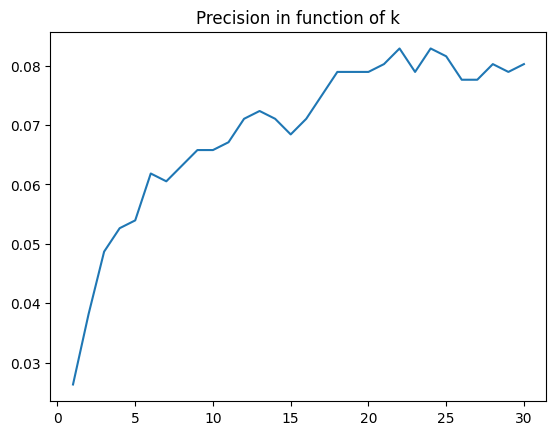

In [52]:
plt.plot(range(1,31),precisions)
plt.title('Precision in function of k')

Let's now try to evaluate our model taking only into account people that played at least 5 games, and by removing 1 game and predicting 10 games for each test player, considering that we have a true positive if the removed game is in the list of 10 games.

In [62]:
played_dict_5 = played_dict.loc[played_dict.map(len)>=5]
len(played_dict_5)

2436

In [63]:
X_train, X_validation, X_test = train_validation_test_split(played_dict_5, validation_size=0.0, test_size=0.2)

In [67]:
#Create and fit the model
SPM = SteamPredictionModel(20)
SPM.fit(X_train)

In [68]:
from tqdm import tqdm

non_zero_dict = hours_encoded.replace(0, np.NaN)
average_played = non_zero_dict.mean(axis=0)

#Evaluate the model
true_positives = 0
false_positives = 0

for player in tqdm(X_test):
    
    player_games = len(player)
    
    games_to_predict = 1 # we search only 1 game
    
    games_for_prediction = {}
    games_removed = []
    n = 0
    for (name,time) in list(player.items()):
        if n < games_to_predict and time >average_played[name]: #the game is liked
            games_removed.append(name)
            n += 1
        else:
            games_for_prediction[name]=time
    
    prediction = list(SPM.predict(games_for_prediction,10).index) #we predict 10 games
    
    if len(games_removed) > 0:
        if games_removed[0] in prediction:
            true_positives += 1
        else:
            false_positives += 1

precision = true_positives/(true_positives+false_positives)

100%|██████████| 487/487 [41:21<00:00,  5.10s/it]    


In [69]:
true_positives, false_positives, precision

(75, 350, 0.17647058823529413)

In [70]:
precision/(1/len(games_list))

628.9411764705882

With this metrics, the prediction is 600x better than random !